# Option pricing with Hull White Model

## 對 Hull White Model 模擬 Short Rate
### Code refer to : [Hull-White-simulation-quantlib-python](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html)

In [2]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

In [10]:
# variables for H-W model
sigma = float(input("Input the market volatility:"))  #市場波動度
a = float(input("Input the constant number in Hull White model: "))  #HW模型常數a
timestep = int(input("Input the total intervals of whole time: "))  #過程中共有幾個間格(月)
length = int(input("Input the total time takes in years: "))  #過程總時間
forward_rate = float(input("Input the forward rate form 0 to t: "))  #遠期利率
day_count = ql.Thirty360()  #30/360計算日方式
todays_date = ql.Date(12, 5, 2020)

Input the market volatility:0.1
Input the constant number in Hull White model: 0.1
Input the total intervals of whole time: 12
Input the total time takes in years: 1
Input the forward rate form 0 to t: 0.05


In [11]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [12]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

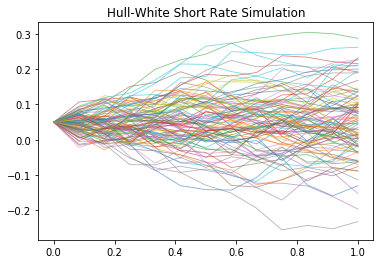

In [19]:
num_paths = 100
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

## 將 Short Rate 代入 GBM，r 換成 r(t) 模擬股價

### Code refer to : [GBM by Teacher Tsai](https://colab.research.google.com/drive/1LL_m1UO_U2oHDMQhBDPjhUBANDpVhev7#scrollTo=nM_mFTMxlLWa)

In [20]:
# Variables for GBM
T = timestep
N = num_paths  # number of paths
dt = 0.01
#mu = 0.01*dt # Yield per unit of time(later be modify by short rate r(t))
#sigma = 0.1  # Given above in H-W model
S0 = 100  # current price of stock
np.random.seed(1)

In [62]:
def genBrownPath (T, mu, sigma, S0, dt):
    
    n = round(T/dt)
    t = time
    W = [0] + np.random.standard_normal(size = n) 
    W = np.cumsum(W)*np.sqrt(dt) # == standard brownian motion
    x = (mu-0.5*sigma**2)*t
    X = np.repeat(x[1:],100) + sigma*W 
    S = S0*np.exp(X) # == geometric brownian motion
    plt.plot(np.linspace(0, 1,1200), S)
    return S

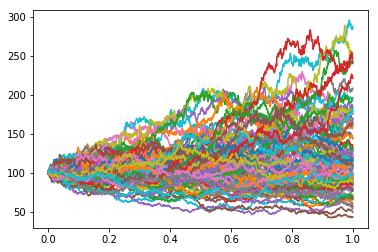

In [63]:
Paths = []
for i in range(N):
    Paths.append(genBrownPath(T, paths[i,:], sigma, S0, dt))
plt.show()

## 自訂選擇權履約價，計算每條 path 到期日之 payoff

In [64]:
Strike = 97
rate = 0.02  # risk-free rate

In [70]:
payoff = []
for i in range(N):
    payoff.append(round(Paths[i][-1]-Strike,2))
print(payoff)

[9.19, 29.79, 67.21, -30.21, -29.77, -54.02, 77.78, 16.37, 26.21, 79.2, 72.25, 62.34, 1.13, -8.19, 3.69, -39.81, 69.74, 34.35, 24.78, -18.66, 18.51, -31.69, 33.24, 36.28, -14.93, 24.24, 18.68, 110.7, -16.94, 95.19, -3.88, -31.48, 32.73, -6.15, -43.27, -29.95, -3.06, -11.64, 13.2, 13.46, 8.6, -2.77, -12.92, 0.71, 87.77, -9.29, 22.64, -35.4, -24.71, 190.77, 46.7, 70.79, 85.97, 19.09, -19.4, -29.23, 82.9, -17.14, 157.33, 11.12, -8.12, -8.62, 144.13, 150.4, 72.18, -47.7, -12.5, -5.23, -6.93, -27.4, -10.2, 47.03, -28.45, -12.25, -20.71, -18.85, 22.96, 17.65, 82.75, 82.2, 30.75, -3.0, -0.28, 143.94, 8.05, 66.69, 20.6, 16.77, 0.75, 15.53, 21.81, 12.17, 98.93, 124.0, 29.94, 11.17, 2.74, -41.14, -8.89, -1.31]


## 計算 Call Price and Put Price

In [78]:
call_psum = put_psum = 0
for i in range(N):
    if payoff[i]>0:
        call_psum += payoff[i]
    else:
        put_psum += -payoff[i]

print("The call price is: %d, and the put price is: %d." \
      %(call_psum*np.exp(-rate*length)/N,put_psum*np.exp(-rate*length)/N))

The call price is: 29, and the put price is: 7.
